In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.misc import factorial

In SQS generation problems, a structure with $n$ total sites must be populated by $m$ types of atoms where the quantity of each $m$ atom is known to be $n_i$ such that $i = {1, 2.. m}$ satisfying $\sum_i^m n_i= n $. 

Generated SQS must find the arrangement of $n$ atoms which minimizes the difference between a correlation function for a completely disordered structure and 

$$ \frac{n!}{\prod_i^m (n_i !)} $$

The worst-case scaling of the atoms assuming a fixed n 

$$ \textrm{max}\left(\frac{n!}{\prod_i^m (n_i !)}\right) = \frac{n!}{\textrm{min}\left(\prod_i^m (n_i !)\right)} = \frac{n!}{\textrm{min}\left(\prod_i^m (n_i !)\right)} = \frac{n!}{\prod_i^m \left(\frac{n}{m}!\right)} = \frac{n!}{ \left(\frac{n}{m}!\right)^m}$$

See https://math.stackexchange.com/questions/565496/maximizing-a-product-of-factorials for an Internet person's proof for the minimia and maxima of $\prod_i^m (n_i !)$. 

I think the derivation could be continued into Gamma functions and then playing with the exponentials, but long story short the growth is exponential.

The scaling of the numerical problem also affected from several aspects:

1. Only the free atoms in a structure contribute towards $n$. If there is a 4 atom binary structure, but mixing is only allowed in a 2 atom sublattice of that structure, then $n = 2$.
2. In order to property reproduce the correlation function, supercells of a structure are often required so $n = kn_{\textrm{unit}}$ for an $n_{\textrm{unit}}$ atom unit cell and $k$ supercells. In the above 10 atom example, a supercell of 4 unit cells might be required, so $n = (4)(2) = 8$

The following code and figures show 

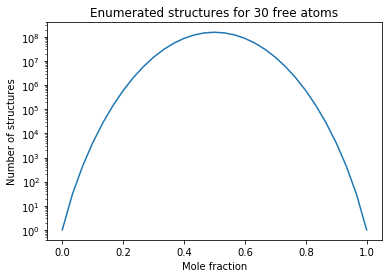

In [2]:
# number of permutations changes for the binary case with 30 atoms
n_atom = 30

a = np.arange(0, n_atom+1)
b = n_atom - a
atoms = np.concatenate([[a],[b]])
n_enum = factorial(n_atom)/np.prod(factorial(atoms), axis=0)
plt.semilogy(a/n_atom, n_enum)
plt.xlabel('Mole fraction')
plt.ylabel('Number of structures')
plt.title('Enumerated structures for {} free atoms'.format(n_atom))

In [3]:
# number of permutations changes for the ternary case with 40 atoms at worst case
n_atom = 30

a = np.array([n_atom/3])
b = np.array([n_atom/3])
c = np.array([n_atom/3])
atoms = np.concatenate([[a],[b], [c]])
n_enum = factorial(n_atom)/np.prod(factorial(atoms), axis=0)
print(n_enum)

[  5.55099679e+12]


In [4]:
times = []
sizes = []
xs = []
import itertools
import time
for na, nb in itertools.product(range(1, 6), repeat=2):
    start = time.time()
    x = len(set(itertools.permutations(na*[0]+nb*[1])))
    end = time.time()
    times.append(end-start)
    sizes.append(na*nb)
    xs.append(x)
print(xs)

[2, 3, 4, 5, 6, 3, 6, 10, 15, 21, 4, 10, 20, 35, 56, 5, 15, 35, 70, 126, 6, 21, 56, 126, 252]


0.0182869513059
4.8815693651


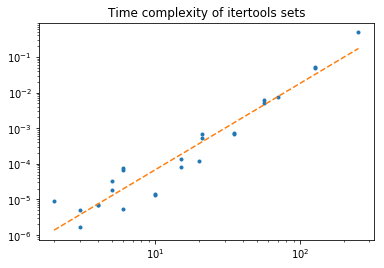

In [5]:
lxs = np.log(xs)
ltimes = np.log(times)
px = np.linspace(np.min(xs), np.max(xs), 100)
pfit = np.polyfit(xs, np.log(times), 1)
p = lambda x: np.exp(np.poly1d(pfit)(x))
pfit = np.polyfit(lxs, (ltimes), 1)
p = lambda x: np.exp(np.poly1d(pfit)(np.log(x)))

plt.loglog(xs, times, '.', px, p(px), '--')

plt.title('Time complexity of itertools sets')
print(p(100))
print(p(1000))

In [6]:
def unique_permutations(seq):
    """
    Yield only unique permutations of seq in an efficient way.

    A python implementation of Knuth's "Algorithm L", also known from the 
    std::next_permutation function of C++, and as the permutation algorithm 
    of Narayana Pandita.
    
    This is taken directly from https://stackoverflow.com/questions/12836385/how-can-i-interleave-or-create-unique-permutations-of-two-stings-without-recurs/12837695#12837695
    It is modified to not sort the list (sorting is commented out)
    """

    # Precalculate the indices we'll be iterating over for speed
    i_indices = range(len(seq) - 1, -1, -1)
    k_indices = i_indices[1:]

    # The algorithm specifies to start with a sorted version
    #seq = sorted(seq)
    seq = list(seq)
    
    while True:
        yield seq

        # Working backwards from the last-but-one index,           k
        # we find the index of the first decrease in value.  0 0 1 0 1 1 1 0
        for k in k_indices:
            if seq[k] < seq[k + 1]:
                break
        else:
            # Introducing the slightly unknown python for-else syntax:
            # else is executed only if the break statement was never reached.
            # If this is the case, seq is weakly decreasing, and we're done.
            return

        # Get item from sequence only once, for speed
        k_val = seq[k]

        # Working backwards starting with the last item,           k     i
        # find the first one greater than the one at k       0 0 1 0 1 1 1 0
        for i in i_indices:
            if k_val < seq[i]:
                break

        # Swap them in the most efficient way
        (seq[k], seq[i]) = (seq[i], seq[k])                #       k     i
                                                           # 0 0 1 1 1 1 0 0

        # Reverse the part after but not                           k
        # including k, also efficiently.                     0 0 1 1 0 0 1 1
        seq[k + 1:] = seq[-1:k:-1]


In [7]:
times_uni = []
sizes_uni = []
xs_uni = []
import time
for na, nb in itertools.product(range(1, 11), repeat=2):
    start = time.time()
    x = len(list(unique_permutations(na*[0]+nb*[1])))
    end = time.time()
    times_uni.append(end-start)
    sizes_uni.append(na*nb)
    xs_uni.append(x)
print(xs_uni)

[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 3, 6, 10, 15, 21, 28, 36, 45, 55, 66, 4, 10, 20, 35, 56, 84, 120, 165, 220, 286, 5, 15, 35, 70, 126, 210, 330, 495, 715, 1001, 6, 21, 56, 126, 252, 462, 792, 1287, 2002, 3003, 7, 28, 84, 210, 462, 924, 1716, 3003, 5005, 8008, 8, 36, 120, 330, 792, 1716, 3432, 6435, 11440, 19448, 9, 45, 165, 495, 1287, 3003, 6435, 12870, 24310, 43758, 10, 55, 220, 715, 2002, 5005, 11440, 24310, 48620, 92378, 11, 66, 286, 1001, 3003, 8008, 19448, 43758, 92378, 184756]


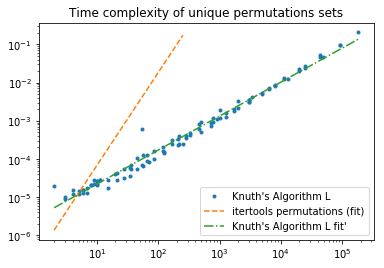

In [8]:
lxs_uni = np.log(xs_uni)
ltimes_uni = np.log(times_uni)
px_uni = np.linspace(np.min(xs_uni), np.max(xs_uni), 100)
pfit_uni = np.polyfit(lxs_uni, (ltimes_uni), 1)
p_uni = lambda x: np.exp(np.poly1d(pfit_uni)(np.log(x)))

plt.loglog((xs_uni), (times_uni), '.', px, p(px), '--', px_uni, p_uni((px_uni)), '-.')
#plt.plot((xs_uni), (times_uni), '.', px_uni, p_uni((px_uni)), '-.')

plt.title('Time complexity of unique permutations sets')
plt.legend(["Knuth's Algorithm L", "itertools permutations (fit)", "Knuth's Algorithm L fit'"])

In [13]:
from pysqs.sqs_enum import unique_permutations as uni_perm
times_uni = []
sizes_uni = []
xs_uni = []
import time
for na, nb in itertools.product(range(1, 11), repeat=2):
    start = time.time()
    print(uni_perm(na*[0]+nb*[1]))
    end = time.time()
    times_uni.append(end-start)
    sizes_uni.append(na*nb)
    xs_uni.append(x)
print(xs_uni)


None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
[184756, 184756, 184756, 184756, 184756, 184756, 184756, 184756, 184756, 184756, 184756, 184756, 184756, 184756, 184756, 184756, 184756, 184756, 184756, 184756, 184756, 184756, 184756, 184756, 184756, 184756, 184756, 184756, 184756, 184756, 184756, 184756, 184756, 184756, 184756, 184756, 184756, 184756, 184756, 184756, 184756, 184756, 184756, 184756, 184756, 184756, 184756, 184756, 184756, 184756, 184756, 184756, 184756, 184756, 184756, 184756, 184756, 184756, 184756, 184756, 184756, 184756, 184

In [207]:
# 30 atom SQS with maximal enumerated structures
print('Enumeration for ternary SQS with 30 free atoms at maximal number of enumerated structures')
print('Time for Knuth\'s Algorithm L (hr)')
print((p_uni(1e10)/3600))
print('Time for itertools permutations (hr)')
print(p(1e10)/3600)
print('Speed increase for Knuth\'s algorithm')
print(p(5e10)/p_uni(5e10))

Enumeration for ternary SQS with 30 free atoms at maximal number of enumerated structures
Time for Knuth's Algorithm L (hr)
1.55308514941
Time for itertools permutations (hr)
1.53207460899e+16
Speed increase for Knuth's algorithm
1.50787974335e+17


In [201]:
# 30 atom SQS with maximal enumerated structures
print('Enumeration for ternary SQS with 30 free atoms at maximal number of enumerated structures')
print('Time for Knuth\'s Algorithm L (hr)')
print((p_uni(1e10)/3600))
print('Time for itertools permutations (hr)')
print(p(1e10)/3600)
print('Speed increase for Knuth\'s algorithm')
print(p(5e10)/p_uni(5e10))

Enumeration for ternary SQS with 30 free atoms at maximal number of enumerated structures
Time for Knuth's Algorithm L (hr)
1.22808386427
Time for itertools permutations (hr)
3.92571837615e+16
Speed increase for Knuth's algorithm
5.37400856702e+17


In [16]:
def num_enumerations(atoms):
    """Calculate the number of enumerations for the atoms passed in.
    
    Parameters
    ----------
    atoms ([int]): List of number of each atom type, e.g. [10,5,5] means 10A-5B-5C
    
    Returns
    -------
    0D ndarray of number of enumerations.
    """
    return factorial(np.sum(atoms))/np.prod(factorial(atoms), axis=0)

In [23]:
p_uni(num_enumerations([24,24]))/3600/8

100.17505156685777